# Linear Regression with Machine Learning -- Part 2

This notebook is for a workshop at STLinATL 2023. It is inspired by the course [Supervised Machine Learning: Regression and Classification](https://www.coursera.org/learn/machine-learning/home/info) by Andrew Ng.


## Problem Statement

You want to use ML to predict housing price given the size of the house. The input (or *feature*) is the size of the house, and the output (or *target*) is the price. Using a training set, you will implement a learning model that calculates the optimal parameters of the model.

We will start with the same two data points as the previous notebook - a house with 1000 square feet sold for \\$300,000 and a house with 2000 square feet sold for \\$500,000.

| Size (1000 sqft)     | Price (1000s of dollars) |
| ----------------| ------------------------ |
| 1               | 300                      |
| 2               | 500                      |


## Goals

You will

- automate the process of optimizing $w$ and $b$ using gradient descent.
- use the model to predict home price for a given size.

## Notation
Here is a summary of the notation we will use.  

|General <img width=70/> <br />  Notation  <img width=70/> | Description<img width=350/>| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar                                                      ||
| $\vec{a}$ | vector                                                      ||
| **Regression** |         |    |     |
|  $\vec{x}$ | inputs, or features: in this notebook, Size (1000 sqft)  | `x_train` |   
|  $\vec{y}$  | output, or targets: in this notebook, Price (1000s of dollars)  | `y_train` 
|  $x^{(i)}$, $y^{(i)}$ | $i_{th}$ training example | `x_i`, `y_i`|
| m | number of training examples | `m`|
|  $w$  |  parameter: weight,                                 | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{w,b}(x^{(i)})$ | The result of the model evaluation at $x^{(i)}$ parameterized by $w,b$: $f_{w,b}(x^{(i)}) = wx^{(i)}+b$  | `f_wb` | 


## Import

Import common Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy

## Training Set

Define the training set.

In [2]:
# x_train is the input variable (size in 1000 square feet)
# y_train is the target (price in 1000s of dollars)
x_train = np.array([1.0, 2.0])
y_train = np.array([300.0, 500.0])
print(f"x_train = {x_train}")
print(f"y_train = {y_train}")

# m is the number of training examples
m = len(x_train)
print(f"Number of training examples is: {m}")

x_train = [1. 2.]
y_train = [300. 500.]
Number of training examples is: 2


## Plot the training set

You can plot the training set using the `scatter()` function in the `matplotlib` library, as shown in the cell below. 

The function arguments `marker` and `c` show the points as red crosses (the default is blue dots). You can use other functions in the `matplotlib` library to set the title and labels to display

In this case, the code needed to plot the training set is in the function `plot_train()` so that we can call it later with a different training set.

In [3]:
def plot_train(x, y):
    """
    Plots the training set
    
    Args:
      x (ndarray (m,)): input features, m samples 
      y (ndarray (m,)): target values
      
    Returns
      fig (Figure): pyplot figure
    """
    
    #create a figure
    fig = plt.figure()
    
    # Plot the data points
    plt.scatter(x_train, y_train, marker='x', c='r')

    # Set the title
    plt.title("Housing Prices")

    # Set the y-axis label
    plt.ylabel('Price (in 1000s of dollars)')

    # Set the x-axis label
    plt.xlabel('Size (1000 sqft)')

    # Display the plot
    plt.show()
    
    return fig

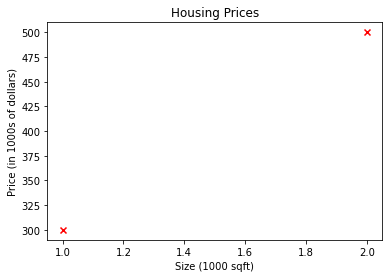

In [4]:
fig = plot_train(x_train,y_train)


## Gradient descent summary

The linear model predicts $f_{w,b}(x^{(i)})$:

$$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{1}$$

In linear regression, you utilize input training data to fit the parameters $w$,$b$ by minimizing a measure of the error between our prediction $f_{w,b}(x^{(i)})$ and the target example $y^{(i)}$. The measure is called the $cost$, $J(w,b)$. In training, you measure the cost over all the training examples $x^{(i)},y^{(i)}$.

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2\tag{2}$$ 


The method of *gradient descent* refers to iteratively changing the value of $w$ and $b$ using:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  

The gradient is defined as:

$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

## Implement Gradient Descent

You will implement gradient descent algorithm for one feature. You will need three functions. 

- `compute_gradient` implementing equations (4) and (5) above
- `compute_cost` implementing equation (2) above (code from previous notebook)
- `gradient_descent` utilizing compute_gradient and compute_cost

Conventions:

- The naming of python variables containing partial derivatives follows this pattern,$\frac{\partial J(w,b)}{\partial b}$  will be `dj_db`.
- w.r.t means "with respect to" such as the partial derivative of $J(wb)$ with repect to $b$.


### Define the model function $f_{wb}(x^{(i)})$

The `calc_f()` python function calculates and returns the prediction, $f_{wb}(x^{(i)})$, for a given input variable.

In [5]:
def calc_f(x, w, b):
    """
    Computes the prediction f_wb of a linear model
    
    Args:
      x (ndarray (m,)): input features, m samples 
      w,b (scalar)    : model parameters  
      
    Returns
      f_wb (ndarray (m,)): target values
    """
    
    m = x.shape[0]
    f_wb = np.zeros(m)
    for i in range(m):
        f_wb[i] = w * x[i] + b
        
    return f_wb

### Define the cost function

The `compute_cost()` python function calculates and returns the cost. It loops through the training examples $x^{(i)}$. In each loop, it:

- calculates the prediction `f_wb`,
- calculates the square of the difference between the prediction and the target,
- adds the contribution to the total cost (sum).

In [6]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    cost_sum = 0 
    for i in range(m): 
        f_wb = w * x[i] + b   
        cost = (f_wb - y[i]) ** 2  
        cost_sum = cost_sum + cost  
    total_cost = (1 / (2 * m)) * cost_sum  

    return total_cost

### compute_gradient

The `compute_gradient()` python function implements equations (4) and (5) above and returns $\frac{\partial J(w,b)}{\partial w}$,$\frac{\partial J(w,b)}{\partial b}$. The embedded comments describe the operations.

In [7]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]    
    dj_dw = 0
    dj_db = 0
    
    dj_dw_sum = 0
    dj_db_sum = 0
    
    for i in range(m):  
        f_wb = w * x[i] + b #calc f
        dj_dw_i = (f_wb - y[i]) * x[i] #calc ith term of dj_dw
        dj_db_i = f_wb - y[i] #calc ith term of dj_db
        dj_dw_sum = dj_dw_sum + dj_dw_i #add the ith term of dj_dw to the sum
        dj_db_sum = dj_db_sum + dj_db_i #add the ith term of dj_db to the sum
    dj_dw = dj_dw_sum / m #divide the sum by m
    dj_db = dj_db_sum / m #divide the sum by m
        
    return dj_dw, dj_db

###  Gradient Descent

Now that gradients can be computed, the method of *gradient descent*, as described in equation (3) above, can be implemented in the python function `gradient_descent()`. The details of the implementation are described in the comments. Below, you will utilize this function to find optimal values of $w$ and $b$ on the training data.

In [8]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function): 
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      num_iters (int):   number of iterations to run gradient descent
      cost_function:     function to call to calculate cost
      gradient_function: function to call to calculate gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """
    
    w = copy.deepcopy(w_in) # avoid modifying global w_in
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dw, dj_db = gradient_function(x, y, w , b)     

        # Update Parameters using equation (3) above
        b = b - alpha * dj_db                            
        w = w - alpha * dj_dw                            

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(x, y, w , b))
            p_history.append([w,b])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")
 
    return w, b, J_history, p_history #return w and J,w history for graphing

## Implement learning model

We will iteratively apply gradient descent to update the values of $w$ and $b$. Every 1000 iterations, we will print the cost, $\frac{\partial J(w,b)}{\partial w}$, $\frac{\partial J(w,b)}{\partial b}$, and the values of $w$ and $b$.

In [9]:
# initialize parameters
w_init = 0
b_init = 0

# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2

# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print()
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 7.93e+04  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00  dj_dw: -3.712e-01, dj_db:  6.007e-01   w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01  dj_dw: -1.789e-01, dj_db:  2.895e-01   w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01  dj_dw: -8.625e-02, dj_db:  1.396e-01   w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02  dj_dw: -4.158e-02, dj_db:  6.727e-02   w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03  dj_dw: -2.004e-02, dj_db:  3.243e-02   w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03  dj_dw: -9.660e-03, dj_db:  1.563e-02   w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04  dj_dw: -4.657e-03, dj_db:  7.535e-03   w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04  dj_dw: -2.245e-03, dj_db:  3.632e-03   w:  2.000e+02, b: 1.00050e+02
Iteration 9000: Cost 2.90e-05  dj_dw: -1.082e-03, dj_db:  1.751e-03   w:  2.000e+02, b: 1.00024e+02


## Exercise 1

1. How does the cost $J(w,b)$ change with each iteration?
2. How do the deriatives $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ change with each iteration?

## Use a larger data set

It's instructive to use a training set with more examples. The training set below includes examples that do not fall on the same line. What does that mean for the cost equation? Can we find $w$, and $b$ that will give us a cost close to 0? 

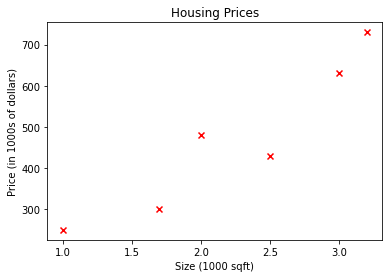

In [10]:
x_train = np.array([1.0, 1.7, 2.0, 2.5, 3.0, 3.2])
y_train = np.array([250, 300, 480,  430,   630, 730,])

fig = plot_train(x_train,y_train)

## Implement the learning model

In [11]:
# initialize parameters
w_init = 0
b_init = 0

# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2

# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print()
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 1.09e+05  dj_dw: -1.170e+03, dj_db: -4.700e+02   w:  1.170e+01, b: 4.70000e+00
Iteration 1000: Cost 1.78e+03  dj_dw: -1.060e+00, dj_db:  2.599e+00   w:  1.974e+02, b: 3.16325e+01
Iteration 2000: Cost 1.74e+03  dj_dw: -4.357e-01, dj_db:  1.068e+00   w:  2.045e+02, b: 1.44256e+01
Iteration 3000: Cost 1.74e+03  dj_dw: -1.790e-01, dj_db:  4.388e-01   w:  2.074e+02, b: 7.35495e+00
Iteration 4000: Cost 1.74e+03  dj_dw: -7.357e-02, dj_db:  1.803e-01   w:  2.085e+02, b: 4.44950e+00
Iteration 5000: Cost 1.74e+03  dj_dw: -3.023e-02, dj_db:  7.410e-02   w:  2.090e+02, b: 3.25559e+00
Iteration 6000: Cost 1.74e+03  dj_dw: -1.242e-02, dj_db:  3.045e-02   w:  2.092e+02, b: 2.76500e+00
Iteration 7000: Cost 1.74e+03  dj_dw: -5.104e-03, dj_db:  1.251e-02   w:  2.093e+02, b: 2.56340e+00
Iteration 8000: Cost 1.74e+03  dj_dw: -2.097e-03, dj_db:  5.141e-03   w:  2.093e+02, b: 2.48056e+00
Iteration 9000: Cost 1.74e+03  dj_dw: -8.619e-04, dj_db:  2.113e-03   w:  2.094e+02, b: 2.44652e+00


### Cost versus iterations of gradient descent 

A plot of cost versus iterations is a useful measure of progress in gradient descent. Cost should always decrease in successful runs. The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.

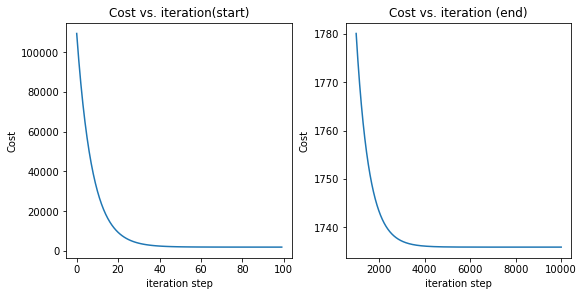

In [12]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()

### Plot the model with the training set

The function below takes the training set and model parameters and plots the model with the training set.

In [13]:
def plot_model_and_train(x, y, w, b):
    """
    Plots the training set with the model's prediction
    
    Args:
      x (ndarray (m,)): input features, m examples 
      y (ndarray (m,)): target values
      w (float or int): weight
      b (float or int): bias
      
    Returns
      fig (Figure): pyplot figure
    """
    
    f_wb = calc_f(x, w, b,)
    
    # Create figure
    fig = plt.figure()

    # Plot our model prediction
    plt.plot(x, f_wb, c='b',label='Our Prediction')

    # Plot the data points
    plt.scatter(x, y, marker='x', c='r',label='Actual Values')

    # Set the title
    plt.title("Housing Prices")
    # Set the y-axis label
    plt.ylabel('Price (in 1000s of dollars)')
    # Set the x-axis label
    plt.xlabel('Size (1000 sqft)')
    plt.legend()
    plt.show()

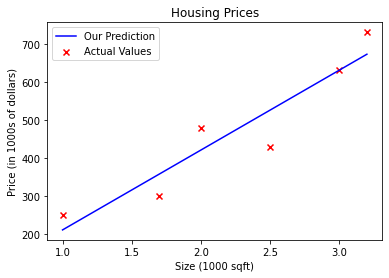

In [14]:
plot_model_and_train(x_train, y_train, w_final, b_final)

## Exercise 2

What does your model predict for the price of a house with 4000 square feet?

Note: the variables `w_final` and `b_final` were assigned to the optimal values of $w$ and $b$ that were found using gradient descent.

## Exercise 3

The results of the gradient descent learning algorithm depend on the value of the learning rate $\alpha$. If the learning rate is too large, the cost will increase instead of decrease.

In the code below, change the variable `tmp_alpha` to 0.31, re-run the learning model, and replot the cost as a function of iteration step. What do you notice?

Iteration    0: Cost 1.27e+05  dj_dw: -1.170e+03, dj_db: -4.700e+02   w:  3.628e+02, b: 1.45700e+02
Iteration 1000: Cost 1.66e+11  dj_dw: -1.347e+06, dj_db: -5.494e+05   w:  2.097e+05, b: 8.54584e+04
Iteration 2000: Cost 2.20e+17  dj_dw: -1.553e+09, dj_db: -6.337e+08   w:  2.416e+08, b: 9.85647e+07
Iteration 3000: Cost 2.93e+23  dj_dw: -1.792e+12, dj_db: -7.309e+11   w:  2.787e+11, b: 1.13684e+11
Iteration 4000: Cost 3.90e+29  dj_dw: -2.066e+15, dj_db: -8.430e+14   w:  3.214e+14, b: 1.31123e+14
Iteration 5000: Cost 5.19e+35  dj_dw: -2.383e+18, dj_db: -9.723e+17   w:  3.707e+17, b: 1.51237e+17
Iteration 6000: Cost 6.90e+41  dj_dw: -2.749e+21, dj_db: -1.121e+21   w:  4.276e+20, b: 1.74437e+20
Iteration 7000: Cost 9.18e+47  dj_dw: -3.171e+24, dj_db: -1.293e+24   w:  4.932e+23, b: 2.01195e+23
Iteration 8000: Cost 1.22e+54  dj_dw: -3.657e+27, dj_db: -1.492e+27   w:  5.688e+26, b: 2.32057e+26
Iteration 9000: Cost 1.63e+60  dj_dw: -4.218e+30, dj_db: -1.721e+30   w:  6.561e+29, b: 2.67655e+29


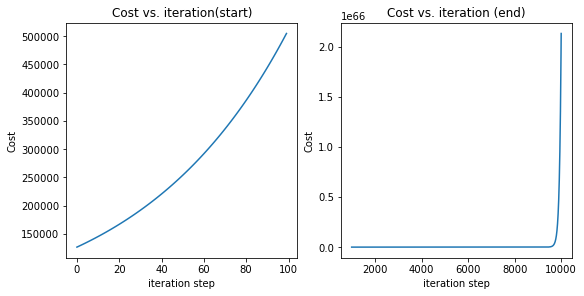

In [15]:
# initialize parameters
w_init = 0
b_init = 0

# some gradient descent settings
iterations = 10000
tmp_alpha = 0.31

# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print()
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()